In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from functools import partial
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np

import os
import random
import shutil
import time

import cv2
import json

from data_tools import dataset_with_mask,superimpose_mask
from unet import UNet
from custom_losses import IoULoss

In [2]:
from trd.utils import use_gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda:1")

In [3]:
# use_gpu(0)
folder = '/mnt/LAIN_EXTERNAL2/waterpolo_anyagok/vizilabda_meccsek/frames'
BATCH_SIZE = 8
EPOCH_NUM = 50
learning_rate = 0.001

In [4]:
train_json = json.load(open('train.json'))
val_json = json.load(open('val.json'))
test_json = json.load(open('test.json'))

train_ds = dataset_with_mask(folder,train_json)
val_ds = dataset_with_mask(folder,val_json)
test_ds = dataset_with_mask(folder,test_json)

In [5]:
train_iterator = data.DataLoader(train_ds, 
                                 batch_size = BATCH_SIZE)
val_iterator = data.DataLoader(val_ds, 
                                batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_ds, 
                                batch_size = BATCH_SIZE)

In [6]:
#net = seq_model#.to(device)
#criterion = nn.MSELoss()#.to(device)
#criterion = nn.L1Loss(reduction = 'none').to(device)
model = UNet(in_channels=3,
             out_channels=1,
             n_blocks=2,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)
#optimizer = optim.Adam(model.parameters(),lr=0.0005)
#optimizer = optim.Adagrad(model.parameters(),lr=0.001)
#net.load_state_dict(torch.load('net_epoch1_0_loss=0.0258271936327219.pt'))

# criterion
criterion = IoULoss()

# optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=0.002)

In [7]:
val_loss = 1
for epoch in range(EPOCH_NUM): 

    running_loss = 0.0
    for i, data in enumerate(train_iterator, 0):
        inputs, labels,fnames = data[0].cuda(), data[1].cuda(),data[2]
        optimizer.zero_grad()
        outputs = model(inputs).cuda()
        #print(np.amin(inputs.cpu().detach().numpy()),np.amax(inputs.cpu().detach().numpy()))
        #print(inputs.shape,labels.shape,outputs.shape)
        
        #print(outputs.shape,labels.shape)
        
        loss_ops = torch.squeeze(outputs,dim=1)
        loss_labs = torch.squeeze(labels,dim=1)
        loss = criterion(loss_ops,loss_labs)#.permute(0,2,1).type(torch.DoubleTensor).to(device), labels.type(torch.DoubleTensor).to(device)).mean(dim=1)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
        prev_loss = 1
        if i % 10 == 0:
            print('[%d, %5d] loss: %.7f' % (epoch + 1, i + 1, running_loss/10))
            
            '''img = inputs[7].cpu().detach().numpy()
            label = labels[7].cpu().detach().numpy()
            pred = outputs[7].cpu().detach().numpy()
            print(np.amin(pred),np.amax(pred))
            
            img = np.moveaxis(img,0,-1)
            label = np.moveaxis(label,0,-1)
            pred = np.moveaxis(pred,0,-1)
            
            img = np.stack((img[:,:,2],img[:,:,1],img[:,:,0]),axis=2)
            
            SI = superimpose_mask(img,label,color_index = 0,grayscale=False) # ground truth: piros
            SI = superimpose_mask(SI,pred,color_index = 1,grayscale=False) # predikció: zöld
            
            plt.figure(figsize = (20,15))
            plt.imshow(SI)
            '''
                
            running_loss = 0.0
        
    for i, data in enumerate(val_iterator, 0):
        inputs, labels,fnames = data[0].cuda(), data[1].cuda(),data[2]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        prev_loss = 1

    print('validation loss: %.7f' % (running_loss / i))
    if running_loss/i < val_loss:
        print('SAVE')
        torch.save(model.state_dict(),"otf_model_net_epoch"+str(epoch)+'_loss='+str(float(running_loss/i))+'.pt')
        val_loss = running_loss/i

/home/csenge/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/csenge/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,     1] loss: 0.0999196
[1,    11] loss: 0.9979403
[1,    21] loss: 0.9969141
[1,    31] loss: 0.9967419
[1,    41] loss: 0.9978906
[1,    51] loss: 0.9972087
[1,    61] loss: 0.9975657


KeyboardInterrupt: 

[1] loss: 0.9971026
225 26720
[2] loss: 0.9959558
80 21100
[3] loss: 0.9967774
192 20981
[4] loss: 0.9951650
255 20470
[5] loss: 0.9940409
224 20862
[6] loss: 0.9949427
135 20985
[7] loss: 0.9963416
180 20434
[8] loss: 0.9939678
255 20406
[9] loss: 0.9937779
234 20019
[10] loss: 0.9936986
143 20176


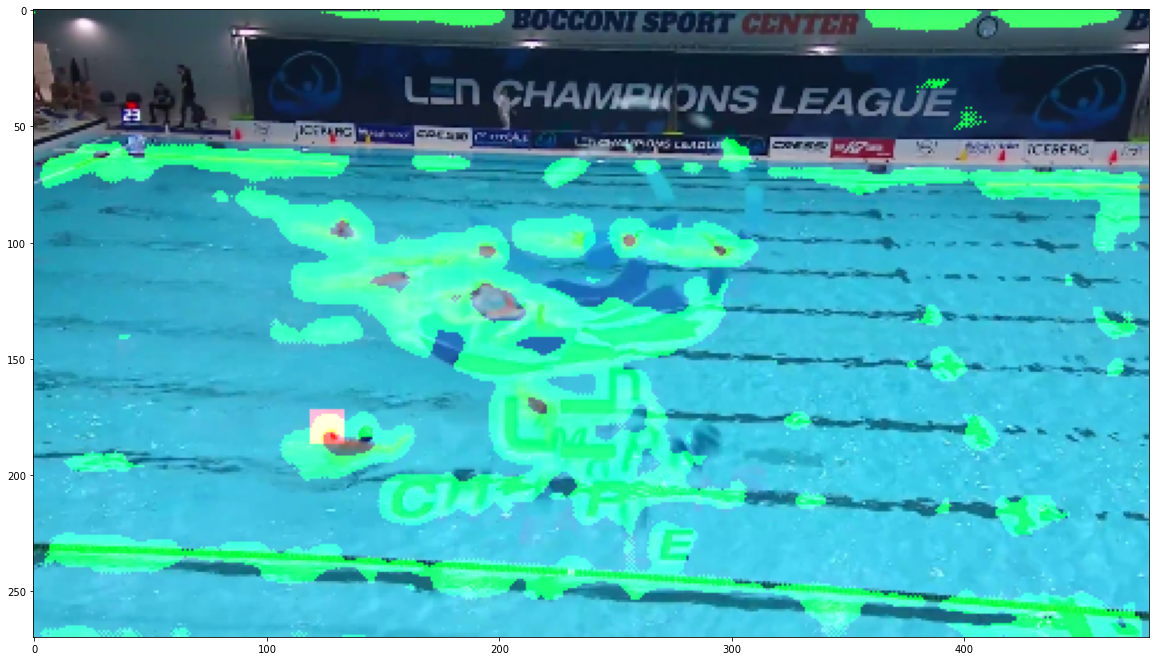

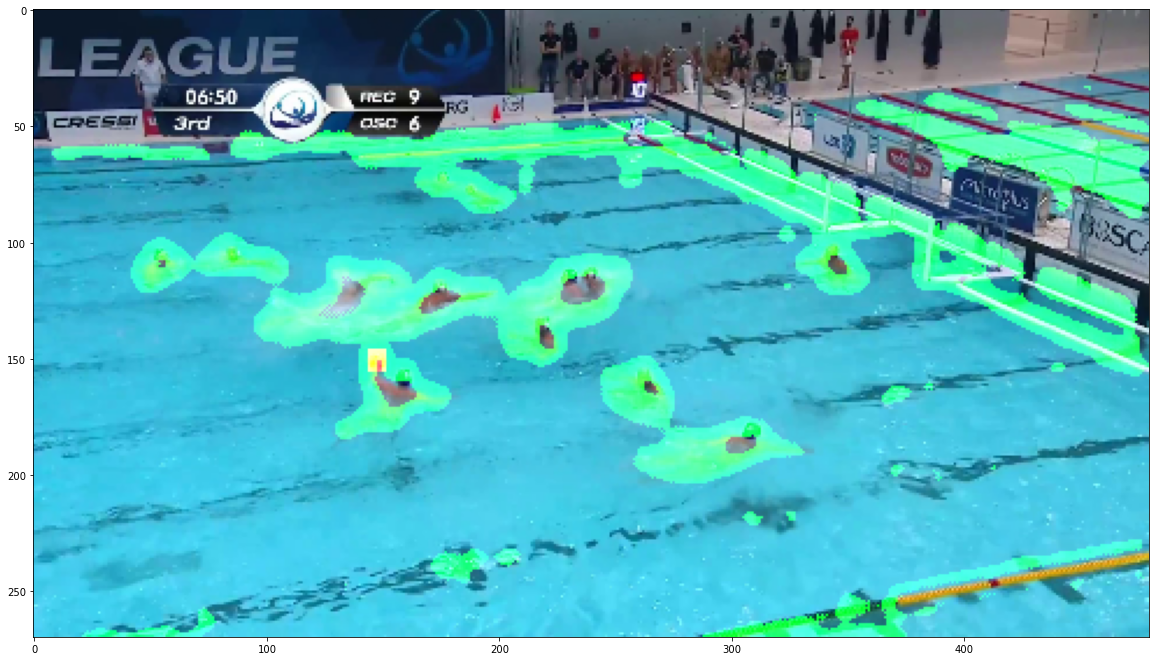

Error in callback <function flush_figures at 0x7f2df0278290> (for post_execute):


KeyboardInterrupt: 

In [8]:
for i, data in enumerate(test_iterator, 0):
    if i < 10:
        inputs, labels,fnames = data[0].cuda(), data[1].cuda(),data[2]

        outputs = model(inputs)
        #outputs = outputs.to(torch.float32)
        loss = criterion(outputs,labels)
        print('[%d] loss: %.7f' % ( i + 1, loss.sum()))

        img = inputs[7].cpu().detach().numpy()
        label = labels[7].cpu().detach().numpy()
        pred = outputs[7].cpu().detach().numpy()
        pred[pred<0.15] = 0
        pred[pred>0.15] = 1

        print(np.count_nonzero(label),np.count_nonzero(pred))
        img = np.moveaxis(img,0,-1)
        label = np.moveaxis(label,0,-1)
        pred = np.moveaxis(pred,0,-1)

        img = np.stack((img[:,:,2],img[:,:,1],img[:,:,0]),axis=2)

        SI = superimpose_mask(img,label,color_index = 0,grayscale=False) # ground truth: piros
        SI = superimpose_mask(SI,pred,color_index = 1,grayscale=False) # predikció: zöld

        plt.figure(figsize = (20,15))
        plt.imshow(SI)
    else:
        break
